<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bs4 as bs
import urllib.request
import multiprocessing
from gensim.models import Word2Vec

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
url = "https://en.wikipedia.org/wiki/How_I_Met_Your_Mother"

In [3]:
raw_html = urllib.request.urlopen(url)
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text

article_text = article_text.lower()

In [4]:
# [article for article in article_text.split("\n") if len(article) > 1]
df = pd.DataFrame([article for article in article_text.split("\n") if len(article.split(" ")) > 3], columns=['data'])
df.head()

,data
0,how i met your mother (often abbreviated as hi...
1,the series was loosely inspired by thomas and ...
2,"known for its unique structure, humor, and inc..."
3,the series follows the adventures of ted mosby...
4,the story goes into a flashback and starts in ...


In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 89


### 1 - Preprocesamiento

In [6]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [7]:
# Demos un vistazo
sentence_tokens[:2]

[['how',
  'i',
  'met',
  'your',
  'mother',
  'often',
  'abbreviated',
  'as',
  'himym',
  'is',
  'an',
  'american',
  'sitcom',
  'created',
  'by',
  'craig',
  'thomas',
  'and',
  'carter',
  'bays',
  'for',
  'cbs',
  'the',
  'series',
  'that',
  'aired',
  'from',
  'september',
  '19',
  '2005',
  'to',
  'march',
  '31',
  '2014',
  'follows',
  'the',
  'main',
  'character',
  'ted',
  'mosby',
  'and',
  'his',
  'group',
  'of',
  'friends',
  'in',
  'new',
  'york',
  "city's",
  'manhattan',
  'as',
  'a',
  'framing',
  'device',
  'ted',
  'in',
  '2030',
  'recounts',
  'to',
  'his',
  'son',
  'luke',
  'and',
  'daughter',
  'penny',
  'the',
  'events',
  'from',
  'september',
  '2005',
  'to',
  'may',
  '2013',
  'that',
  'led',
  'him',
  'to',
  'meet',
  'their',
  'mother',
  'how',
  'i',
  'met',
  'your',
  'mother',
  'is',
  'a',
  'joint',
  'production',
  'by',
  'bays',
  'thomas',
  'productions',
  'and',
  '20th',
  'century',
  'fox'

### 2 - Crear los vectores (word2vec)

In [8]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobracargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [9]:
# Crearmos el modelo generador de vectoeres
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=2,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     size=200,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [10]:
# Buildear el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [11]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 89


In [12]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.vocab))

Cantidad de words distintas en el corpus: 879


### 3 - Entrenar el modelo generador

In [13]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 164859.046875
Loss after epoch 1: 70122.640625
Loss after epoch 2: 60459.09375
Loss after epoch 3: 58956.96875
Loss after epoch 4: 58830.0625
Loss after epoch 5: 57488.46875
Loss after epoch 6: 58542.09375
Loss after epoch 7: 58757.9375
Loss after epoch 8: 58193.6875
Loss after epoch 9: 59339.0625
Loss after epoch 10: 59305.625
Loss after epoch 11: 59132.3125
Loss after epoch 12: 60782.0625
Loss after epoch 13: 59781.125
Loss after epoch 14: 58643.375
Loss after epoch 15: 57083.5625
Loss after epoch 16: 50413.875
Loss after epoch 17: 51569.25
Loss after epoch 18: 51053.625
Loss after epoch 19: 51162.375


(97977, 168920)

### 4 - Ensayar

In [14]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["marshall"], topn=10)

[('lily', 0.9986733794212341),
 ('robin', 0.9982640147209167),
 ('ted', 0.9967214465141296),
 ('as', 0.9965038299560547),
 ('to', 0.9963786602020264),
 ('and', 0.9958627223968506),
 ('decide', 0.9956835508346558),
 ('has', 0.9954761266708374),
 ('are', 0.9953210353851318),
 ('two', 0.9952080845832825)]

In [15]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["marshall"], topn=10)

[('your', -0.5306453704833984),
 ('i', -0.5591138601303101),
 ('met', -0.5624810457229614),
 ('how', -0.5774234533309937),
 ('mother', -0.63506019115448),
 ('father', -0.7693716883659363),
 ('dad', -0.866765022277832),
 ('would', -0.9103946685791016),
 ('story', -0.9187871217727661),
 ('he', -0.922858476638794)]

In [16]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["met"], topn=10)

[('how', 0.996337890625),
 ('i', 0.9950397610664368),
 ('your', 0.9945573806762695),
 ('mother', 0.9939974546432495),
 ('father', 0.9593509435653687),
 ('dad', 0.8983405232429504),
 ('would', 0.8482005596160889),
 ('story', 0.839599609375),
 ('he', 0.8338348865509033),
 ('does', 0.8261674642562866)]

In [17]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["mother"], topn=10)

[('met', 0.9939975142478943),
 ('i', 0.993930995464325),
 ('how', 0.9926943778991699),
 ('your', 0.987413763999939),
 ('father', 0.9815158247947693),
 ('dad', 0.9345552921295166),
 ('would', 0.8917652368545532),
 ('story', 0.8857783079147339),
 ('he', 0.8815419673919678),
 ('does', 0.8737363219261169)]

### 5 - Visualizar agrupación de vectores

In [18]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model):
    num_dimensions = 2  

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [19]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


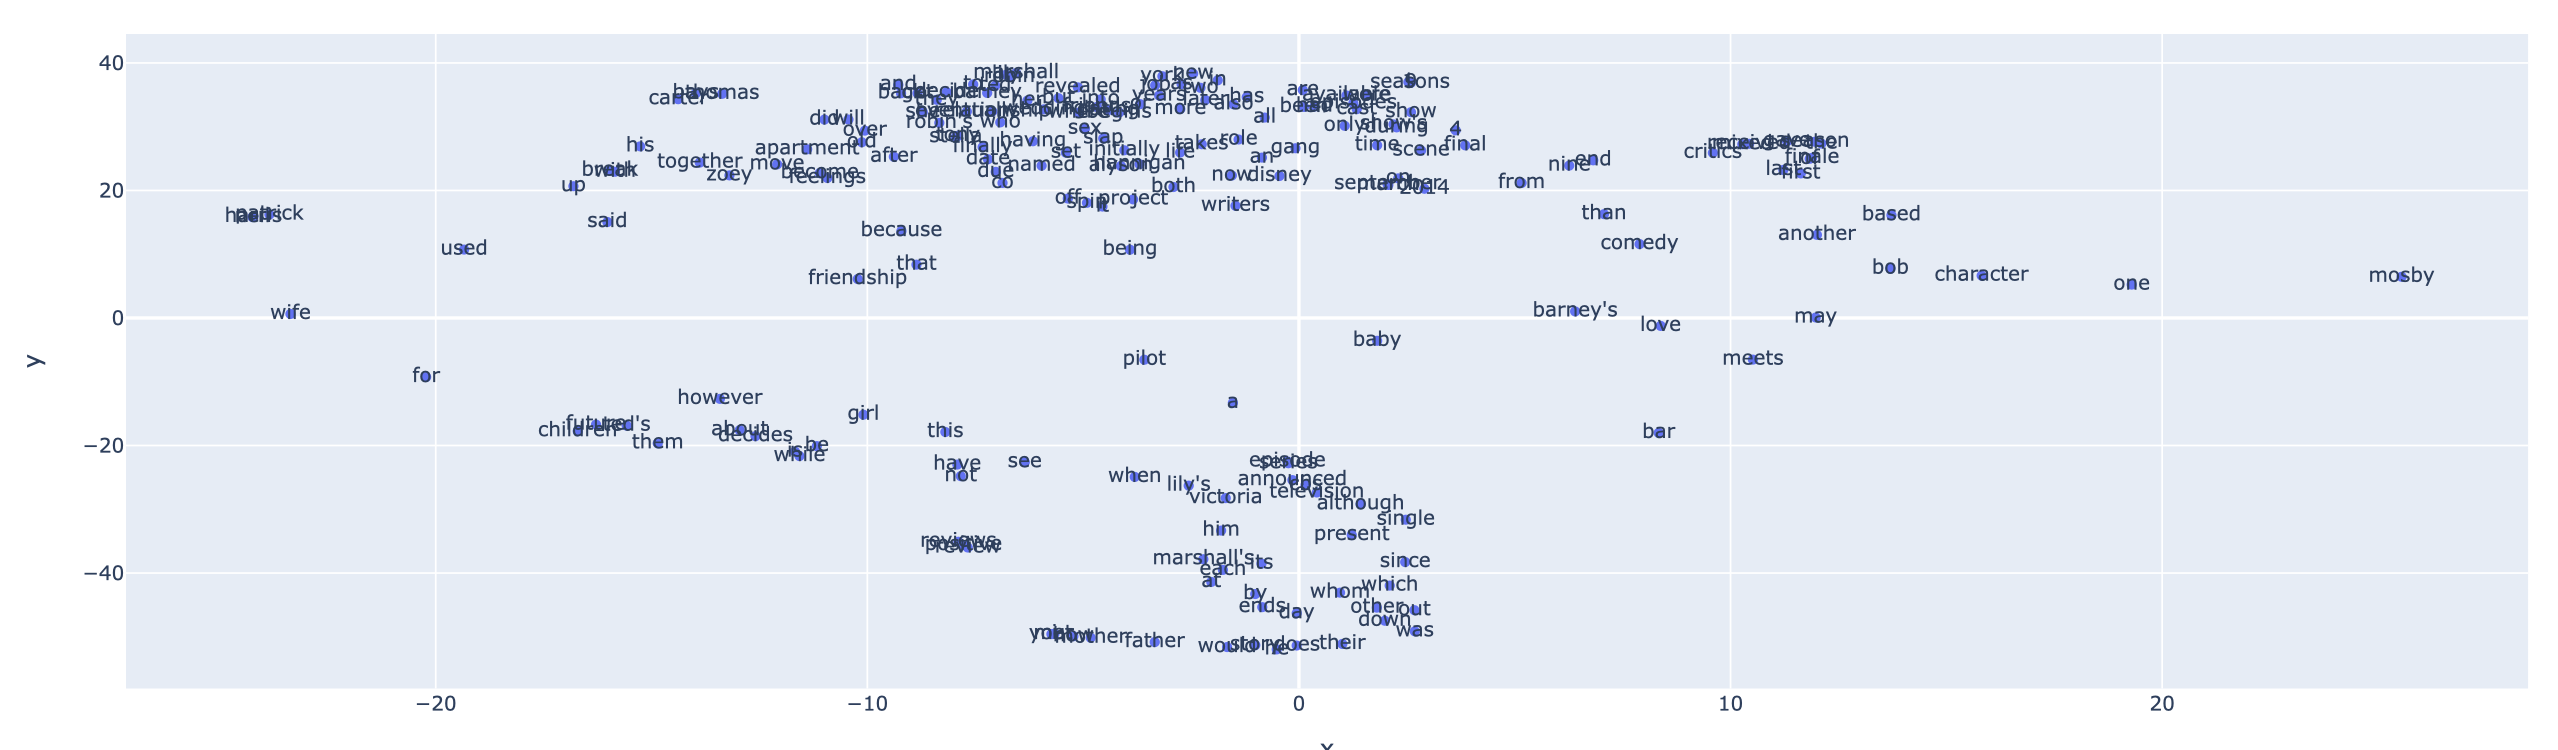